# Part II: Get metadata

- Number of transcripts per cell and per gene
- Relate original cell ID with `ndimage` one
- Some other data related to cell and overall concentration

In [1]:
import numpy as np
import pandas as pd
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats
from matplotlib import pyplot as plt

from importlib import reload
import utils

# Load all general data

- Same setup as in Part I

In [2]:
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
psrc = '../proc/'
osrc = '../data/'
sample = 'A2'

dst = '../kde/'

dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
nuclei = tf.imread(nsrc + sample + '_EDT.tif') < 1
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

print('Detected',cellnum,'cells')

Detected 1216 cells


- Load all the CSVs with spatial locations

In [3]:
filenames = sorted(glob(tsrc + sample + os.sep + '*.csv'))
tsize = np.zeros(len(filenames), dtype=int)
transcriptomes = [os.path.splitext(filenames[i])[0].split('_-_')[-1] for i in range(len(filenames)) ]
translocs = [None for i in range(len(filenames))]
for i in range(len(filenames)):
    translocs[i] = pd.read_csv(filenames[i], header=None, names=['X', 'Y', 'Z'])
    tsize[i] = len(translocs[i])
tlocs = pd.concat(translocs)

# Compute metadata

Get metadata for every cell
-  Lower-left and upper right corners of the minimal bounding box containing the cell
-  Length and height of such box
-  Total cell area
-  Total area occupied by nuclei
-  Total area occupied by cytosol
-  Cytosol-to-total area ratio
-  Center of mass according to the original data
-  Center of mass according to `ndimage` computed right now
-  Cell ID from the original data

The index is the label ID matched from `ndimage` (matching done by comparing centers of mass)

In [35]:
reload(utils)
filename = dst + sample + '_cells_metadata.csv'
print(filename)
if not os.path.isfile(filename):
    celllocs = utils.celllocs_read(osrc + sample + '_data/' + transcriptomes[1] + '/' + transcriptomes[1] + ' - localization results by cell.csv')
    dcoords, cnuclei, argmatches, orig_cellID = utils.match_original_ndimage(celllocs, wall, label, cellnum)
    objss = ndimage.find_objects(label)
    meta = utils.generate_cell_metadata(label, objss, nuclei)
    orig_com = np.round(dcoords[argmatches], 2)
    orig_com[orig_cellID == 0] = 0
    meta = meta.join(pd.DataFrame( orig_com, columns=['orig_comX', 'orig_comY']))
    meta = meta.join(pd.DataFrame(np.round(np.flip(cnuclei, axis=1),2), columns=['ndimage_comX', 'ndimage_comY']))
    meta['orig_cellID'] = orig_cellID
    meta['ndimage_cellID'] = np.arange(1,cellnum+1)
    meta.set_index(keys=['ndimage_cellID']).to_csv(filename, index_label='ndimage_cellID')

metacell = pd.read_csv(filename, index_col=0)
print('Number of unmatched ndimage labels:\t', len(metacell.loc[metacell['orig_cellID'] == 0]) )
uq, ct = np.unique(metacell.loc[metacell['orig_cellID'] > 0, 'orig_cellID'].values, return_counts=True)
print(np.sum(ct > 1))
print(metacell.shape)
metacell.loc[:,['length', 'height']].describe().astype(int).T

../kde/A2/A2_cells_metadata.csv
0
(1216, 15)


,count,mean,std,min,25%,50%,75%,max
length,1216,212,422,11,71,114,215,10723
height,1216,234,550,11,74,121,221,15008


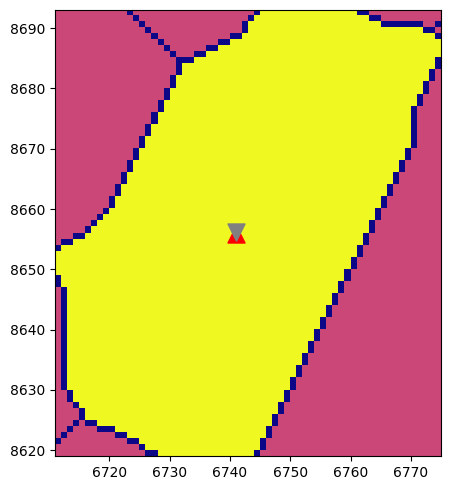

In [36]:
PP = 0
cidx = 950

ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx ] = 2
cell[~wall[ss]] = 0

fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(cell, origin='lower', cmap='plasma', extent=extent)
ax[i].scatter(*metacell.loc[cidx, ['orig_comX', 'orig_comY']].values, c='red', marker='^', s=150)
ax[i].scatter(*metacell.loc[cidx, ['ndimage_comX', 'ndimage_comY']].values, c='gray', marker='v', s=150)
fig.tight_layout();

Get metadata for every gene

- Total number of transcripts throughout the cross section
- Total number of transcripts floating in cytosol
- Total number floating in nuclei
- Cytosolic-to-total transcript ratio

In [37]:
filename = dst + sample + '_transcripts_metadata.csv'
print(filename)
if not os.path.isfile(filename):
    data = pd.read_csv(osrc + sample + '_data' + os.sep + '32771-slide1_' + sample + '_results.txt', header=None, sep='\t').drop(columns=[4])
    _, orig_size = np.unique(data.iloc[:,-1], return_index = False, return_inverse=False, return_counts=True) 
    meta = pd.DataFrame()
    meta['total_number'] = orig_size
    meta['cyto_number'] = tsize
    meta['nuclei_number'] = orig_size - tsize
    meta['ratio'] = tsize/orig_size
    meta['gene'] = transcriptomes
    
    meta.to_csv(filename, index=False)

metatrans = pd.read_csv(filename)
metatrans.head()

../kde/A2/A2_transcripts_metadata.csv


,total_number,cyto_number,nuclei_number,ratio,gene
0,45,45,0,1.000000,BAC45727
1,54,54,0,1.000000,BAC46169
2,517,506,11,0.978723,BAC47034
3,32,32,0,1.000000,BAC47856
4,37,36,1,0.972973,BAC48395


Get metadata for every cell and gene

- Number of transcripts of a given gene in a given cell

In [38]:
filename = dst + sample + '_transcells_metadata.csv'
print(filename)
if not os.path.isfile(filename):
    meta = utils.generate_transcell_metadata(translocs, transcriptomes, cellnum, label)
    meta.to_csv(filename, index=False)
transcell = pd.read_csv(filename)
transcell.head()

../kde/A2/A2_transcells_metadata.csv


,1,2,3,4,5,6,7,8,9,10,...,1208,1209,1210,1211,1212,1213,1214,1215,1216,gene
0,11,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,BAC45727
1,13,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,BAC46169
2,108,0,6,0,2,0,0,2,1,0,...,1,0,0,2,0,1,0,0,0,BAC47034
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BAC47856
4,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BAC48395
